In [6]:
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def Bilinear(orig_image, new_width, new_height):
    new_x, new_y = np.meshgrid(np.arange(new_height), np.arange(new_width))
    orig_x = new_x / (new_width - 1) * (orig_image.shape[1] - 1)
    orig_y = new_y / (new_height - 1) * (orig_image.shape[0] - 1)
    x1 = orig_x.astype(int)
    y1 = orig_y.astype(int)
    x2 = np.clip(x1 + 1, 0, orig_image.shape[1] - 1)
    y2 = np.clip(y1 + 1, 0, orig_image.shape[0] - 1)
    dx = orig_x - x1
    dy = orig_y - y1
    dx = np.expand_dims(dx, axis=-1)
    dy = np.expand_dims(dy, axis=-1)
    result = (1 - dx) * (1 - dy) * orig_image[y1, x1] + \
             dx * (1 - dy) * orig_image[y1, x2] + \
             (1 - dx) * dy * orig_image[y2, x1] + \
             dx * dy * orig_image[y2, x2]
    return result.astype(np.uint8)

[array([[8.3189994e-22, 1.0000000e+00, 1.4355801e-10]], dtype=float32), array([[149.66733 , 105.108826]], dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


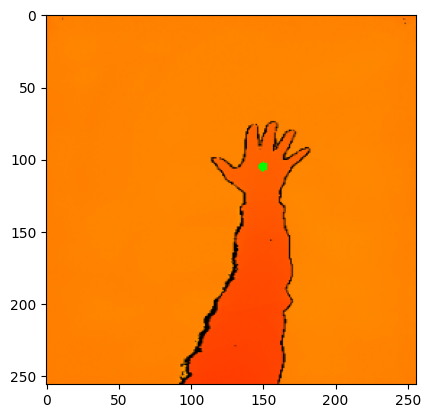

In [11]:
img = Image.open("TestData/Images/OpenHand/255.png")
img = Bilinear(np.array(img), 256, 256)
img = img/255.0


# Load the ONNX model
sess = onnxruntime.InferenceSession("AIOv4.onnx")
intput_name = sess.get_inputs()[0].name
outputs = sess.get_outputs()
output_one = outputs[0].name
output_two = outputs[1].name
image = img.astype(np.float32)

onnx_predicted_label = sess.run(output_names=[output_one, output_two], input_feed={intput_name: image.reshape(1,256,256,3)})
print(onnx_predicted_label)

for x in range(256):
    for y in range(256):
        if((x - onnx_predicted_label[1][0][0])**2 + (y - onnx_predicted_label[1][0][1])**2 < 10):
            img[y][x] = [0, 255, 0]

plt.imshow(img)
plt.show()